# Find out on which weekday people bike the most with groupby and aggregate

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-4", port=8080)

Starting pandas-test-domain-4 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/9d93c458c001460ab1e25c78b755c632.sqlite



# Data owner: upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.service.project.project import Project
from syft.util.util import autocache, PANDAS_DATA

In [6]:
df = pd.read_csv(autocache(f"{PANDAS_DATA}/bikes.csv"), sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


## Create mock data

In [7]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [8]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(df))],
                    data=[get_mock_row(i) for i in range(len(df))],
                    columns=df.columns)

Upload the data

In [9]:
dataset = sy.Dataset(name="bikes2",
                     asset_list=[sy.Asset(name="bikes", data=df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]

Uploading: bikes


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## create Data scientist

In [10]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

## Create user account

# Data Scientist: create syft_function

## Download mock and submit project

### Get mock

In [11]:
ds = guest_domain_client.datasets[0]

In [12]:
asset = ds.assets["bikes"]

In [13]:
asset

```python
Asset: bikes
Pointer Id: 6459ca06b7d542e3a828f731497c801a
Description: None
Total Data Subjects: 0
Shape: (310, 9)
Contributors: 0

```

In [14]:
bikes = asset.mock.syft_action_data

### Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<AxesSubplot: >

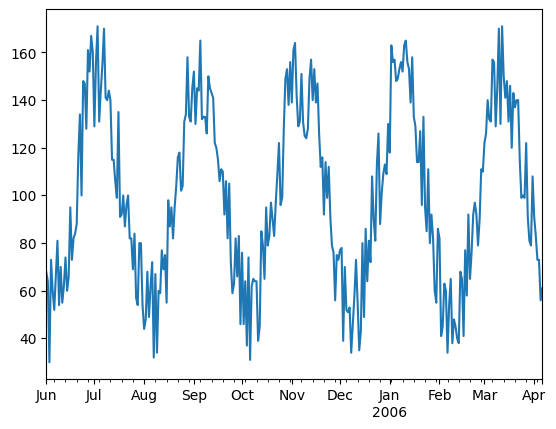

In [15]:
bikes['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [16]:
berri_bikes = bikes[['Berri 1']].copy()

In [17]:
berri_bikes[:5]

,Berri 1
2005-06-01,68
2005-06-02,64
2005-06-03,30
2005-06-04,73
2005-06-05,60


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [18]:
berri_bikes.index

DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [19]:
berri_bikes.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [20]:
berri_bikes.index.weekday

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [21]:
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
berri_bikes[:5]

,Berri 1,weekday
2005-06-01,68,2
2005-06-02,64,3
2005-06-03,30,4
2005-06-04,73,5
2005-06-05,60,6


### Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [22]:
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
weekday_counts

,Berri 1
weekday,
0,4388
1,4369
2,4571
3,4423
4,4413
5,4432
6,4503


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [23]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

<AxesSubplot: xlabel='weekday'>

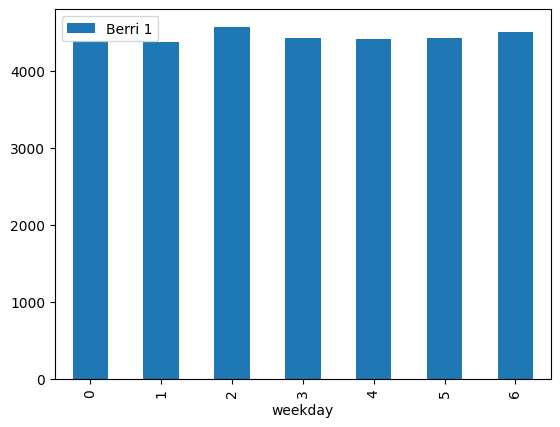

In [24]:
weekday_counts.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

### Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [25]:
# Todo, fix indexes in function

In [26]:
@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

Request code execution

In [27]:
req = guest_domain_client.api.services.code.request_code_execution(get_bike_hist)

In [28]:
submitted_code = guest_domain_client.code[0]

In [29]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [30]:
new_project = sy.Project(name="Pandas Chapter 4",
                         description="Hi, I would like to plot histogram of bikers per weekday")

In [31]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [32]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute syft_function

In [33]:
from syft import MessageStatus

In [34]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Get messages

In [35]:
messages = root_domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [36]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,deee7690687b443fb12daa1a09bcf6d8,Approval Request,MessageStatus.UNDELIVERED,2023-05-16 08:52:04,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,8a2ce16b21f846fc97d0acc97eba9a68,Project Approval,MessageStatus.UNDELIVERED,2023-05-16 08:52:05,<<class 'syft.service.project.project.Project'...


In [37]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [39]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [40]:
func

```python
class UserCode:
  id: str = 6ace011dc8194001a458ed13f1cef311
  node_uid: str = 9d93c458c001460ab1e25c78b755c632
  user_verify_key: str = 97a237303acfb544db2a870f3c660fa4d0c79a9a7a79228945d888abcbb0e40b
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-4', verify_key=0998efca576ed4859d243a97d30253827059160f9ec9a135e99f66b8e61c0b62): {'bikes': <UID: 6459ca06b7d542e3a828f731497c801a>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_bike_hist_97a237303acfb544db2a870f3c660fa4d0c79a9a7a79228945d888abcbb0e40b_8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558(bikes):

    def get_bike_hist(bikes):
        berri_bikes = bikes[['Berri 1']].copy()
        berri_bikes.loc[:, 'weekday'] = berri_bikes.index.weekday
        weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
        return weekday_counts
    result = get_bike_hist(bikes=bikes)
    return result"
  service_func_name: str = "get_bike_hist"
  unique_func_name: str = "user_func_get_bike_hist_97a237303acfb544db2a870f3c660fa4d0c79a9a7a79228945d888abcbb0e40b_8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558"
  user_unique_func_name: str = "user_func_get_bike_hist_97a237303acfb544db2a870f3c660fa4d0c79a9a7a79228945d888abcbb0e40b"
  code_hash: str = "8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558"
  signature: str = (bikes)
  status: str = {NodeView(node_name='pandas-test-domain-4', verify_key=0998efca576ed4859d243a97d30253827059160f9ec9a135e99f66b8e61c0b62): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['bikes']
  enclave_metadata: str = None

```

In [41]:
get_col_user_function = func.unsafe_function

In [42]:
real_data = root_domain_client.datasets[0].assets[0].data

In [43]:
real_result = get_col_user_function(bikes=real_data)

In [44]:
bikes=real_data.syft_action_data
berri_bikes = bikes[['Berri 1']].copy()
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
real_result = weekday_counts

In [45]:
real_result[:3]

,Berri 1
weekday,
0,134298
1,135305
2,152972


In [46]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [47]:
asset = guest_client.datasets[0].assets[0]

In [48]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-4', verify_key=0998efca576ed4859d243a97d30253827059160f9ec9a135e99f66b8e61c0b62): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<AxesSubplot: xlabel='weekday'>

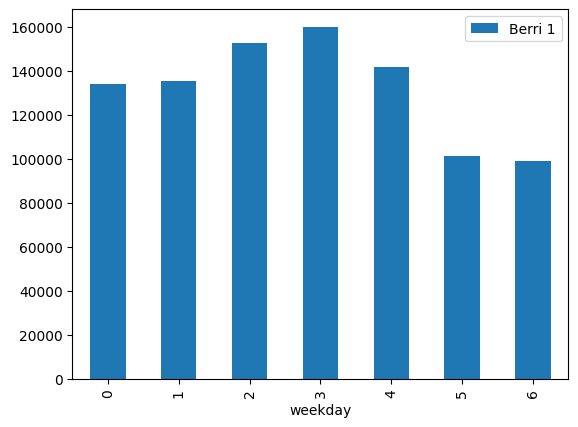

In [49]:
real_result = guest_client.api.services.code.get_bike_hist(bikes=asset)
real_result.plot(kind="bar")